# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [ ]:
# drive.mount('/content/drive')

# Task 1: Sparsity and Robustness

Please add your solution to this task from the manual in the cells below.

$x = [1, 1, 1, 6, 1, 1]$. The goal is to minimize this loss function to find the estimate of $z$.

### $L_0$ Loss

$L_2(z) = \sum_{i=1}^{6} (x_i - z)^2$

In [2]:
x=[1,1,1,6,1,1]
z=1
z_l2_hat = np.mean(x)
float(z_l2_hat)

1.8333333333333333

Here are the \( L_1 \) and \( L_0 \) loss functions written in LaTeX:

### $L_1$ Loss:

$L_1(z) = \sum_{i=1}^{6} |x_i - z|$

$L_1$ loss is given by the median of the sorted array

In [3]:
x_sorted = x.copy()
x_sorted.sort()
z_l1_hat = np.median(x_sorted)
float(z_l1_hat)

1.0

### $L_0$ Loss:

$L_0(z) = \sum_{i=1}^{6} \mathbb{I}(x_i \neq z)$

L0 loss is gien by the mode of the vector $x$

In [4]:
import scipy.stats
z_l0_hat = scipy.stats.mode(x).mode
float(z_l0_hat)

1.0

# Task 4: ISTA Extension to Matrices and Inclusion of Rank Constraints

So far, we have been working with vectors and sparsity constraints. We now introduce two new challenges:

1. Introducing rank constraints into our problem formulation.
2. Extending our algorithms to matrices (can be used to deal with images, videos etc.)

Note that the rank of a matrix describes the degree of correlation between its rows or columns. A low rank means that most of its rows or columns are similar. In the context of images, a low rank component could be used to represent a background (e.g. a grassy background would have large regions of highly similar pixel values). In the context of videos (assume that each frame is being treated as a vector of dimension $hw$ (height $\times$ width) so that the columns of a matrix represent each frame), a low rank component could represent similarities between successive frames. In other words, such an approach could help us identify constant features and isolating things that change. This is used frequently in medical imaging techniques to isolate outliers from largely similar video/image frames that show blood or tissue.

Mathematically, the rank of a matrix can be captured by the nuclear norm of a matrix $||\mathbf{M}||_{*}$ which basically counts the number of non-zero singular values of $\mathbf{M}$.
The singular values are the non zero elements of the diagonal matrix $\mathbf{\Sigma}$ in the singular value decomposition (SVD) of $\mathbf{M} = \mathbf{U \Sigma V}^{T}$.

Our problem is that we are given some observation $\mathbf{X} \in \mathbb{R}^{a \times b}$ (an image or a video for example) and our objective is to recover a low rank component $\mathbf{L} \in \mathbb{R}^{a \times b}$ and sparse component $\mathbf{S} \in \mathbb{R}^{a \times b}$ such that $\mathbf{X} = \mathbf{AL} + \mathbf{BS}$ where $\mathbf{A}$ and $\mathbf{B}$ represent some linear operations (this is similar to $\mathbf{A}$ in the original least squares regression problem. Also note that in many cases it may be sufficient to for these to be identity matrices, but we shall generalize our formulation). Overall, our optimization problem is:

$$
\begin{align}
\arg \min_{\mathbf{L, S}}{\lambda_{1}||\mathbf{L}||_{*} + \lambda_{2}||\mathbf{S}||_{1} + ||\mathbf{X} - \mathbf{AL} - \mathbf{BS}||_{F}^{2}}
\end{align}
$$

This is also known as Robust Principal Component Analysis (RPCA).

Without going into more details here, the ISTA approach can be extended to this problem formulation via the following two update equations:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(
(\mathbf{I} - \frac{1}{L_f} \mathbf{A}^T \mathbf{A}) \mathbf{L}_k - \mathbf{A}^T \mathbf{B} \mathbf{S}_k + \mathbf{A}^T \mathbf{X}, \frac{\lambda_1}{L_f}) \\
\mathbf{S}_{k+1} &= \text{soft}((\mathbf{I} - \frac{1}{L_f} \mathbf{B}^T \mathbf{B}) \mathbf{S}_k - \mathbf{B}^T \mathbf{A} \mathbf{L}_k + \mathbf{B}^T \mathbf{X}, \frac{\lambda_2}{L_f})
\end{align}
$$

You have already seen the soft thresholding operator, the singular value thresholding operator is the proximal gradient operator for the nuclear norm and is defined as follows:

$$
\begin{align}
\text{svt}(\mathbf{X}, \kappa) := \mathbf{U} \, \max(\mathbf{0}, \mathbf{\Sigma} - \kappa\mathbf{I}) \, \mathbf{V}^T
\end{align}
$$

where $\mathbf{U \Sigma V}^{T} = \text{SVD}(\mathbf{X})$

Our focus is not on the details of this optimization algorithm. We shall instead focus on designing a neural network inspired by it.

Note that for each update equation, we can replace the multiplicative matrices by learnable convolutional kernels and thresholds by learnable parameters so that each iteration (layer) looks as follows:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(C_{1}^{k} * \mathbf{L}_{k} + C_{2}^{k} * \mathbf{S}_{k} + C_{3}^{k} * \mathbf{X}, \mu_{1})\\
\mathbf{S}_{k+1} &= \text{soft}(K_{1}^{k} * \mathbf{L}_{k} + K_{2}^{k} * \mathbf{S}_{k} + K_{3}^{k} * \mathbf{X}, \mu_{2})
\end{align}
$$

where $C_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{L}$ network and $K_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{S}$ network.

You will be working with the moving MNIST dataset for this problem. Each sample $\mathbf{X} \in \mathbb{R}^{64 \times 64}$ represents a frame from a video containing two mnist digits superimposed on a noisy, low rank background. The functions given below will help you load and visualize the dataset.

In [5]:
class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = torch.tensor(np.array(L), dtype=torch.float32)
        self.S = torch.tensor(np.array(S), dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)

        self.L = self.L.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.S = self.S.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.X = self.X.view(10, 1000, 64 * 64).permute(1, 2, 0)

        self.L = self.L.unsqueeze(1)
        self.S = self.S.unsqueeze(1)
        self.X = self.X.unsqueeze(1)

        print("L shape:", self.L.shape)
        print("S shape:", self.S.shape)
        print("X shape:", self.X.shape)

    def __len__(self):
        return self.L.size(0)

    def __getitem__(self, idx):
        L_seq = self.L[idx]
        S_seq = self.S[idx]
        X_seq = self.X[idx]

        return L_seq, S_seq, X_seq


In [6]:
def load_mnist(filename='moving_mnist.pkl'):
    with open(filename, 'rb') as f:
        L, S, X = pickle.load(f)
    return L, S, X

In [7]:
# DO NOT MODIFY
filename = "/home/jovyan/moving_mnist.pkl"
L, S, X = load_mnist(filename=filename)
dataset = MovingMNISTDataset(L, S, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
print("size of training dataset:", train_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L shape: torch.Size([1000, 1, 4096, 10])
S shape: torch.Size([1000, 1, 4096, 10])
X shape: torch.Size([1000, 1, 4096, 10])
size of training dataset: 800


Original X shape: (10000, 64, 64)
Original L shape: (10000, 64, 64)
Original S shape: (10000, 64, 64)

Plots for Original


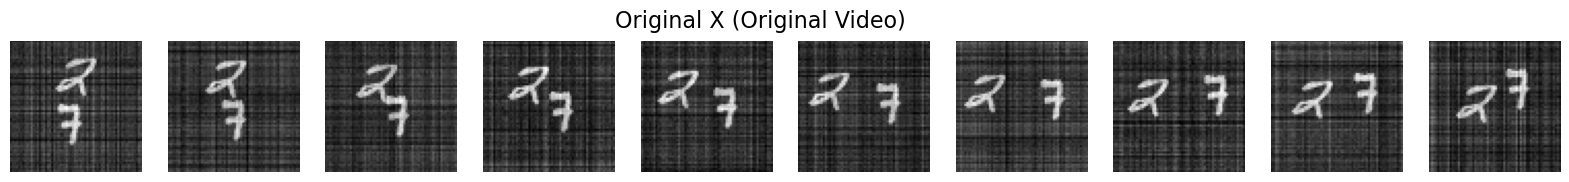

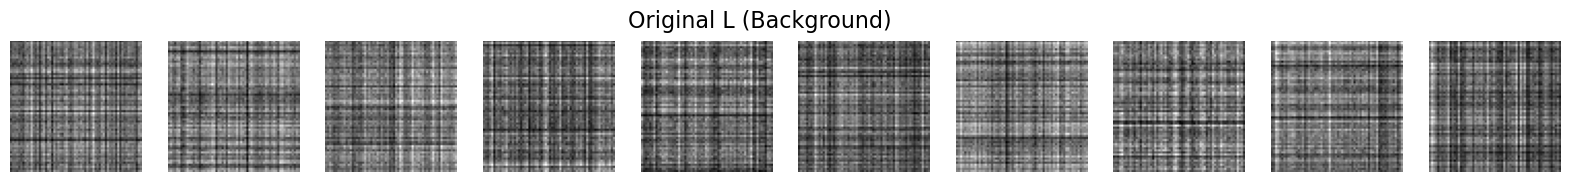

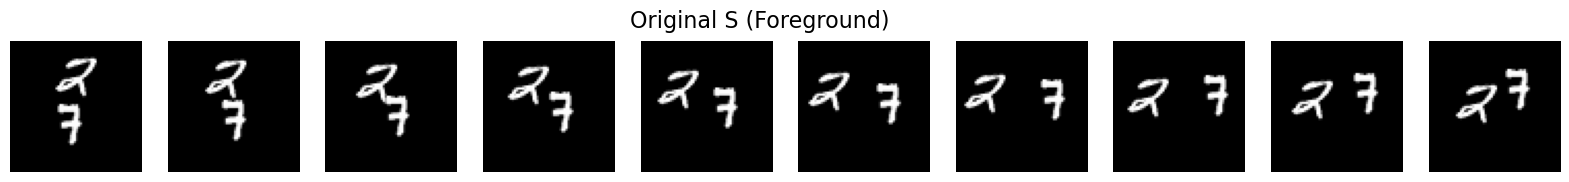



Transformed L_new shape: torch.Size([1, 4096, 10])
Transformed S_new shape: torch.Size([1, 4096, 10])
Transformed X_new shape: torch.Size([1, 4096, 10])


In [8]:
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
def plot_video_frames(data, title):
    video_idx = 0  # Selecting the first video (index 0)
    frames = data[:10]  # Shape: (10, 64, 64)

    # Create a figure with 10 subplots (one for each frame)
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

# Plot original X, L, and S
print("\nPlots for Original")
plot_video_frames(X, "Original X (Original Video)")
plot_video_frames(L, "Original L (Background)")
plot_video_frames(S, "Original S (Foreground)")

# Simulating transformation via the dataset
# L_new, S_new, X_new represent transformed data after the dataloader
L_new, S_new, X_new = dataset[0]  # Dataset returns transformed tensors

# Display the shape of transformed data (L_new, S_new, X_new)
print("\n")
print("Transformed L_new shape:", L_new.shape)
print("Transformed S_new shape:", S_new.shape)
print("Transformed X_new shape:", X_new.shape)


Now design a neural network with up to 5 layers based on the intuition for low rank and sparse solutions developed above. Each layer should contain two branches for performing proximal operations for the low rank and sparse component respectively.

During training, plot the following:
1. MSE Loss as a function of the number of epochs.
2. Final values of learnt thresholding parameters for the L and S brances as a function of layer number.

For the test data, plot the following two charts by averaging over all points:
1. Low Rank:
  - 3D plot showing layer number and index of singular value on the x and y axes and the singular values themselves on the z axis.

2. Sparse:
  - 2D plot showing layer number on the x axis and number of sparse values on the y axis.

In [9]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the ISTA block with linear layers and a learnable threshold."""
        super(ISTABlock, self).__init__()
        self.branch = branch  # 'L' or 'S'

        # Since each frame is a vector of size 4096, we can use Linear layers
        self.linear1 = nn.Linear(4096, 4096)
        # self.linear2 = nn.Linear(4096, 4096)
        # self.linear3 = nn.Linear(4096, 4096)

        # Initialize learnable threshold parameter
        self.threshold = nn.Parameter(torch.tensor(0.1))
    
    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        return torch.sign(X) * torch.nn.functional.relu(torch.abs(X) - thr)
    
    def _svt(self, X, thr):
        """Apply Singular Value Thresholding (SVT) to the input tensor."""
        batch_size, time_steps, num_features = X.shape
        # Reshape X to (batch_size * time_steps, 64, 64)
        X_reshaped = X.view(-1, 64, 64)
        # Perform SVD on each frame
        U, S, Vh = torch.linalg.svd(X_reshaped)
        # Apply thresholding
        S_thresholded = torch.nn.functional.relu(S - thr)
        # Reconstruct the frames
        S_thresholded = torch.diag_embed(S_thresholded)
        X_reconstructed = torch.matmul(U, torch.matmul(S_thresholded, Vh))
        # Flatten back to original shape
        X_reconstructed = X_reconstructed.view(batch_size, time_steps, -1)
        return X_reconstructed

    def forward(self, L_k, S_k, X):
        """Perform the forward pass through the ISTA block based on the branch type."""
        if self.branch == 'L':
            out = self.linear1(L_k)# + self.linear2(S_k) + self.linear3(X)
            out = self._svt(out, self.threshold)
        elif self.branch == 'S':
            out = self.linear1(L_k)# + self.linear2(S_k) + self.linear3(X)
            out = self._soft(out, self.threshold)
        return out

class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with ISTA blocks for both 'S' and 'L' branches."""
        super(UnfoldedDNN, self).__init__()
        num_layers = configs["num_layers"]
        self.L_layers = nn.ModuleList()
        self.S_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.L_layers.append(ISTABlock('L'))
            self.S_layers.append(ISTABlock('S'))
    
    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        thresholds_L = [layer.threshold.item() for layer in self.L_layers]
        thresholds_S = [layer.threshold.item() for layer in self.S_layers]
        return thresholds_L, thresholds_S
    
    def forward(self, X):
        """Perform the forward pass through the unfolded neural network and return activations."""
        activations_L = []
        activations_S = []
        batch_size, time_steps, num_features = X.shape
        L_k = torch.zeros_like(X)
        S_k = torch.zeros_like(X)
        for L_layer, S_layer in zip(self.L_layers, self.S_layers):
            L_k = L_layer(L_k, S_k, X)
            S_k = S_layer(L_k, S_k, X)
            activations_L.append(L_k)
            activations_S.append(S_k)
        return (activations_L, activations_S), (L_k, S_k)

Now Train the Model and evaluate the outputs. Complete the plotting functions and feel free to change the configurations or training settings

In [10]:
def plot_mse_loss(epoch_losses):
    """
    Plot MSE loss over epochs.
    """
    plt.figure()
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
    plt.title('MSE Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()


def plot_threshold_params(L_params, S_params):
    """
    Plot threshold parameters for L and S branches across layers.
    """
    # Get thresholds from the last epoch
    last_L_params = L_params[-1]
    last_S_params = S_params[-1]
    layers = range(1, len(last_L_params)+1)
    plt.figure()
    plt.plot(layers, last_L_params, label='L Branch')
    plt.plot(layers, last_S_params, label='S Branch')
    plt.title('Threshold Parameters vs Layer Number')
    plt.xlabel('Layer Number')
    plt.ylabel('Threshold Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_singular_values(L_):
    """
    Calculate singular values from the low-rank component.
    Handles input of shape [batch_size, time_steps, num_features].
    """
    batch_size, time_steps, num_features = L_.shape
    
    singular_values_list = []

    for i in range(batch_size):
        for t in range(time_steps):
            l = L_[i, t, :].cpu().numpy()
            # Reshape if needed to ensure it forms a 2D matrix for SVD
            if len(l.shape) == 1:
                l = l.reshape(-1, 1)
            
            U, S, Vh = np.linalg.svd(l, full_matrices=False)
            singular_values_list.append(S)

    # Convert the list to an array for easier manipulation
    singular_values_array = np.array(singular_values_list)
    avg_singular_values = np.mean(singular_values_array, axis=0)

    return avg_singular_values


def get_sparsity(S_, tol=1e-6):
    """
    Calculate sparsity (number of non-zero elements with tolerance 10^-6) from the sparse component.
    """
    batch_size = S_.size(0)
    total_elements = S_[0].numel()
    num_nonzero_list = []
    for i in range(batch_size):
        s = S_[i]
        num_nonzero = (torch.abs(s) > tol).sum().item()
        num_nonzero_list.append(num_nonzero)
    avg_num_nonzero = np.mean(num_nonzero_list)
    return avg_num_nonzero

def plot_singular_values_over_layers(singular_values):
    """
    Plot singular values for each layer as a 3D surface plot.
    """
    singular_values = np.array(singular_values).transpose()  # Shape: (num_layers, num_singular_values)
    num_layers, num_singular_values = singular_values.shape

    # Adjust meshgrid: X for layers, Y for singular value indices
    X, Y = np.meshgrid(range(1, num_singular_values + 1), range(1, num_layers + 1))
    Z = singular_values  # Keep it as is without transposing

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface with a colormap
    surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    

    # Add a color bar for better interpretation
    fig.colorbar(surface, shrink=0.5, aspect=5)

    # Set labels and title
    ax.set_xlabel('Singular Value Index')
    ax.set_ylabel('Layer Number')
    ax.set_zlabel('Singular Value')
    ax.set_title('Singular Values over Layers')

    # Adjust view angle for better visualization
    ax.view_init(30, -30)

    plt.show()


def plot_sparse_values_over_layers(sparse_values):
    """
    Plot average number of sparse values across layers.
    """
    layers = range(1, len(sparse_values)+1)
    plt.figure()
    plt.plot(layers, sparse_values, marker='o')
    plt.title('Average Number of Sparse Values over Layers')
    plt.xlabel('Layer Number')
    plt.ylabel('Average Number of Non-zero Elements')
    plt.grid(True)
    plt.show()

In [14]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []
    L_params = []
    S_params = []

    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{configs['epochs']}]", unit="batch") as pbar:
            for L, S, X in pbar:
                L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
                optimizer.zero_grad()
                # Removes dimensions with size 1 along the 1st axis
                X = X.squeeze(1)
                L = L.squeeze(1)
                S = S.squeeze(1)
                # swap dimensions to [batch_size, time_steps, num_features]
                X = X.permute(0, 2, 1) 
                L = L.permute(0, 2, 1)
                S = S.permute(0, 2, 1)
                _, (L_, S_) = model(X)
                loss = loss_fn(L_, S_, L, S, X)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * L.size(0)
                pbar.set_postfix(loss=running_loss / len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)

        thresholds_S, thresholds_L = model.get_thresholds()
        L_params.append(thresholds_L)
        S_params.append(thresholds_S)

        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    plot_mse_loss(epoch_losses)
    print("\n")
    plot_threshold_params(L_params, S_params)


def evaluate(model, test_loader, loss_fn, configs):
    model.eval()
    running_loss = 0.0
    all_sparsities = []
    all_singular_values = []

    with torch.no_grad():
        for batch_idx, (L, S, X) in enumerate(test_loader):
            # Removes dimensions with size 1 along the 1st axis
            X = X.squeeze(1)
            L = L.squeeze(1)
            S = S.squeeze(1)
            # swap dimensions to [batch_size, time_steps, num_features]
            X = X.permute(0, 2, 1) 
            L = L.permute(0, 2, 1)
            S = S.permute(0, 2, 1)
            L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
            (activations_L, activations_S), (L_ , S_)= model(X)
            loss = loss_fn(L, S, L_, S_, X)
            running_loss += loss.item() * L.size(0)

            print(f"Plot for random frame in {batch_idx}")
            plot_first_frame(L, S, X)
            print(f"Plot for random predicted frame in {batch_idx}")
            plot_first_frame(L_, S_, X)

            batch_singular_values = []
            batch_sparsities = []
            layer_idx = 0
            for L_layer, S_layer in zip(activations_L, activations_S):
                layer_idx += 1
                singular_values = get_singular_values(L_layer)
                sparsity = get_sparsity(S_layer)
                batch_singular_values.append(singular_values[0])
                batch_sparsities.append(sparsity)
            all_singular_values.append(batch_singular_values)
            all_sparsities.append(batch_sparsities)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")
    print("all_singular_values:", all_singular_values)
    # avg_singular_values = np.mean(all_singular_values, axis=0)
    avg_sparsities = np.mean(all_sparsities, axis=0)
    print("all_sparsities", all_sparsities)
    print("avg_sparsities", avg_sparsities)

    plot_singular_values_over_layers(all_singular_values)
    print("\n")
    plot_sparse_values_over_layers(avg_sparsities)
    return avg_loss


def plot_first_frame(L, S, X):
    # print(L.shape)
    L_frame_flat = L[0, 0, :]  # Shape: (4096,)
    S_frame_flat = S[0, 0, :]  # Shape: (4096,)
    X_frame_flat = X[0, 0, :]  # Shape: (4096,)
    
    L_frame = L_frame_flat.view(64, 64).cpu().numpy()
    S_frame = S_frame_flat.view(64, 64).cpu().numpy()
    X_frame = X_frame_flat.view(64, 64).cpu().numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].imshow(L_frame, cmap='gray')
    axs[0].set_title('Background (L)')
    axs[0].axis('off')
    
    axs[1].imshow(S_frame, cmap='gray')
    axs[1].set_title('Foreground (S)')
    axs[1].axis('off')
    
    axs[2].imshow(X_frame, cmap='gray')
    axs[2].set_title('Original (D)')
    axs[2].axis('off')
    
    plt.show()


def loss_fn(L_, S_, L, S, X):
    loss_L = torch.nn.functional.mse_loss(L_, L)
    loss_S = torch.nn.functional.mse_loss(S_, S)
    return loss_L + loss_S


Epoch [1/30]: 100%|██████████| 25/25 [00:52<00:00,  2.08s/batch, loss=0.0915]


Epoch: [1/30], Loss: 0.0915


Epoch [2/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0518]


Epoch: [2/30], Loss: 0.0518


Epoch [3/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0439]


Epoch: [3/30], Loss: 0.0439


Epoch [4/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0381]


Epoch: [4/30], Loss: 0.0381


Epoch [5/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0339]


Epoch: [5/30], Loss: 0.0339


Epoch [6/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=0.0296]


Epoch: [6/30], Loss: 0.0296


Epoch [7/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0267]


Epoch: [7/30], Loss: 0.0267


Epoch [8/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0246]


Epoch: [8/30], Loss: 0.0246


Epoch [9/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0231] 


Epoch: [9/30], Loss: 0.0231


Epoch [10/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0203] 


Epoch: [10/30], Loss: 0.0203


Epoch [11/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=0.0196] 


Epoch: [11/30], Loss: 0.0196


Epoch [12/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0171] 


Epoch: [12/30], Loss: 0.0171


Epoch [13/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0172] 


Epoch: [13/30], Loss: 0.0172


Epoch [14/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0152] 


Epoch: [14/30], Loss: 0.0152


Epoch [15/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.014]  


Epoch: [15/30], Loss: 0.0140


Epoch [16/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0133] 


Epoch: [16/30], Loss: 0.0133


Epoch [17/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0128] 


Epoch: [17/30], Loss: 0.0128


Epoch [18/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0124] 


Epoch: [18/30], Loss: 0.0124


Epoch [19/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=0.0116] 


Epoch: [19/30], Loss: 0.0116


Epoch [20/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0117] 


Epoch: [20/30], Loss: 0.0117


Epoch [21/30]: 100%|██████████| 25/25 [00:50<00:00,  2.04s/batch, loss=0.0108] 


Epoch: [21/30], Loss: 0.0108


Epoch [22/30]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/batch, loss=0.0104] 


Epoch: [22/30], Loss: 0.0104


Epoch [23/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.00993]


Epoch: [23/30], Loss: 0.0099


Epoch [24/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.0115] 


Epoch: [24/30], Loss: 0.0115


Epoch [25/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.00963]


Epoch: [25/30], Loss: 0.0096


Epoch [26/30]: 100%|██████████| 25/25 [00:50<00:00,  2.03s/batch, loss=0.00952]


Epoch: [26/30], Loss: 0.0095


Epoch [27/30]: 100%|██████████| 25/25 [00:51<00:00,  2.04s/batch, loss=0.00932]


Epoch: [27/30], Loss: 0.0093


Epoch [28/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.00878]


Epoch: [28/30], Loss: 0.0088


Epoch [29/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.00872]


Epoch: [29/30], Loss: 0.0087


Epoch [30/30]: 100%|██████████| 25/25 [00:51<00:00,  2.05s/batch, loss=0.0086] 


Epoch: [30/30], Loss: 0.0086


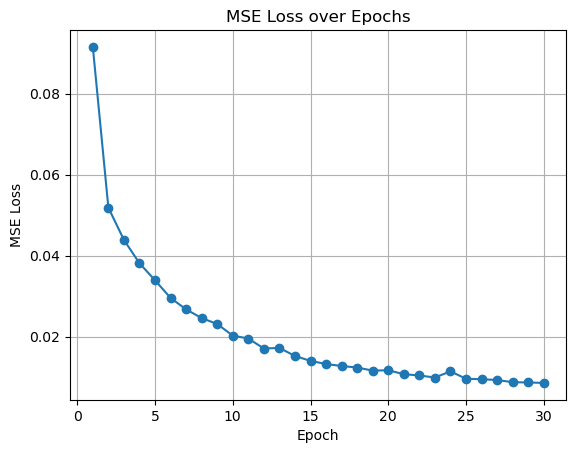

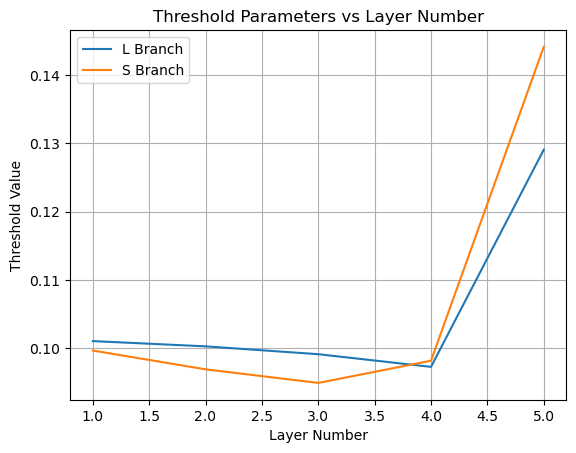

In [12]:
# Model and training configurations
configs = {
    "num_layers": 5,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Plot for random frame in 0


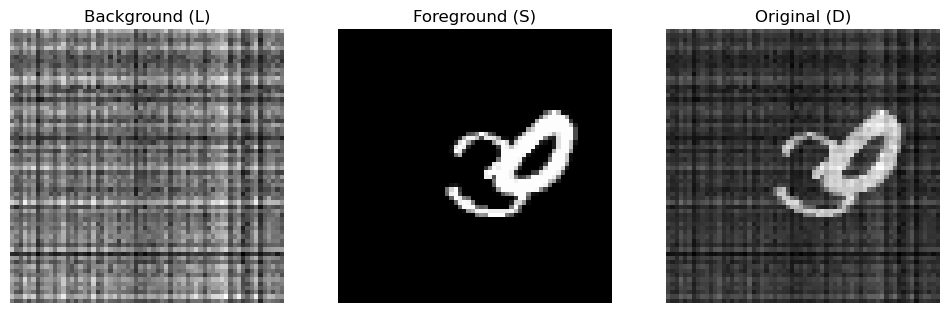

Plot for random predicted frame in 0


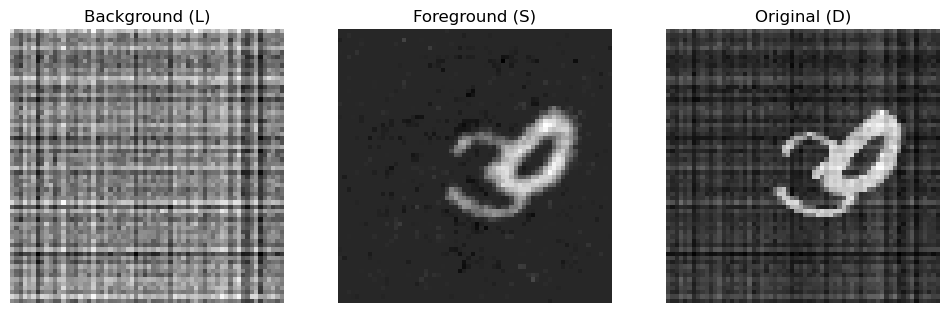

Plot for random frame in 1


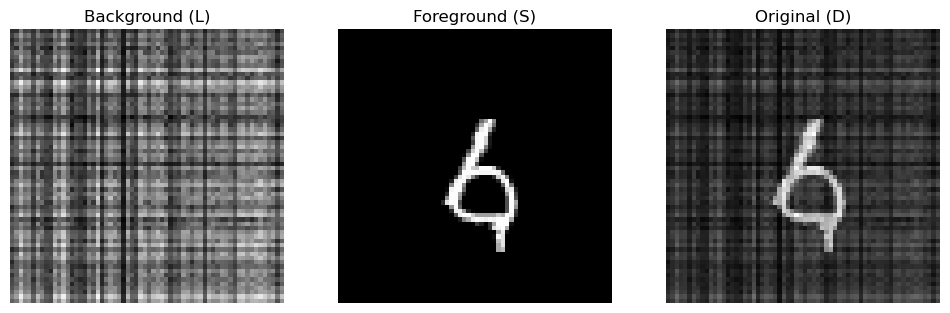

Plot for random predicted frame in 1


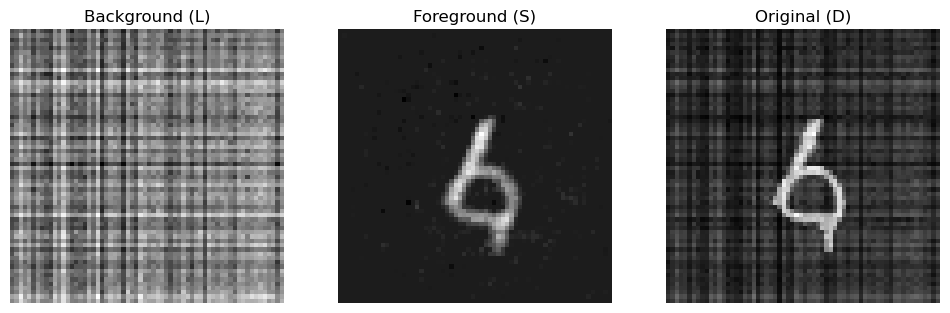

Plot for random frame in 2


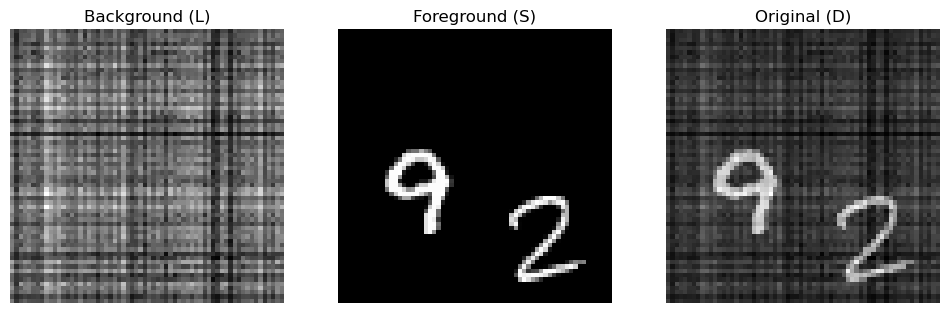

Plot for random predicted frame in 2


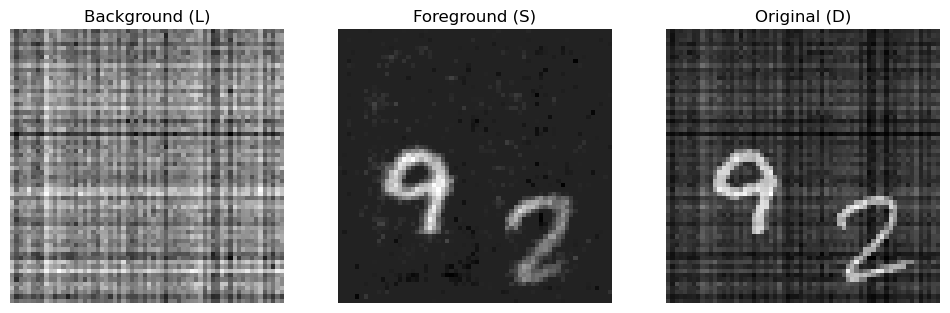

Plot for random frame in 3


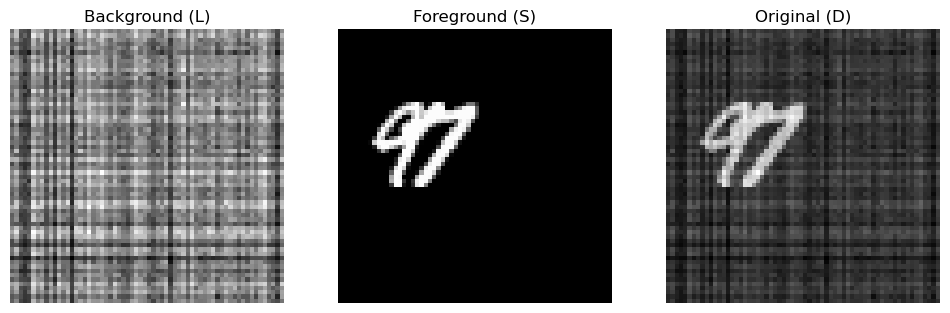

Plot for random predicted frame in 3


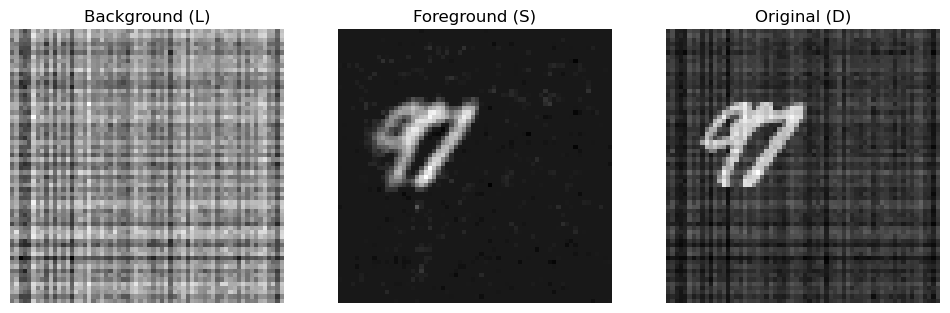

Plot for random frame in 4


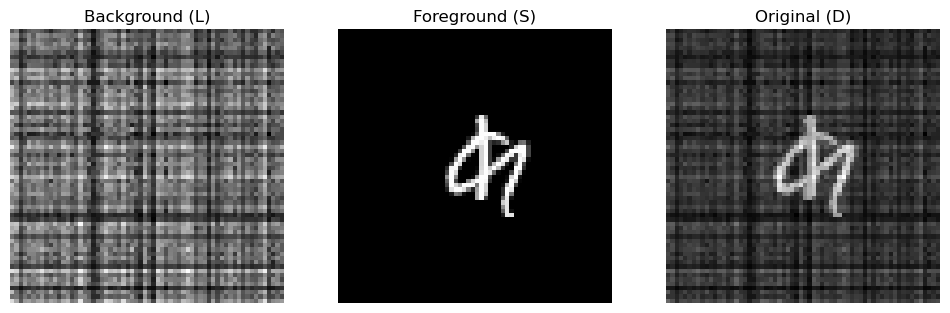

Plot for random predicted frame in 4


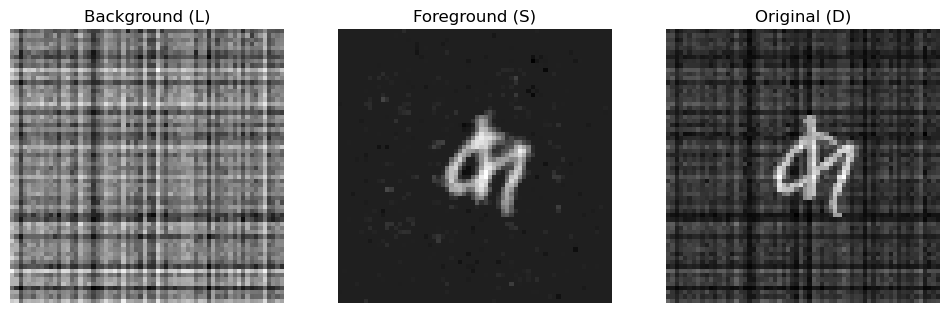

Plot for random frame in 5


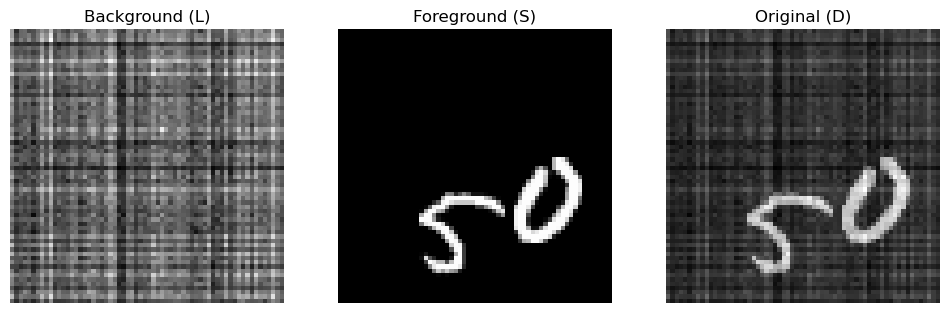

Plot for random predicted frame in 5


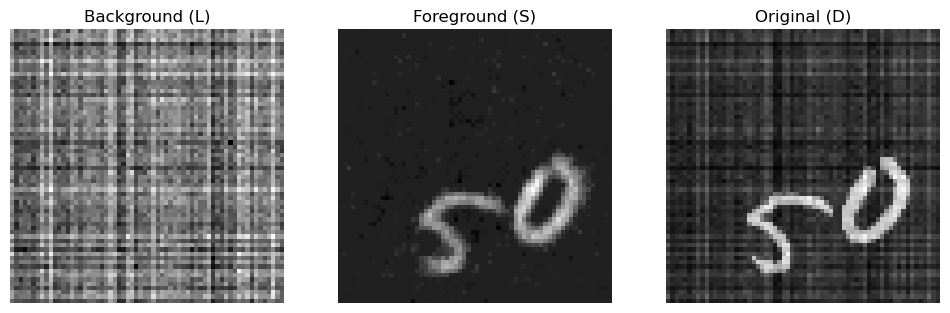

Plot for random frame in 6


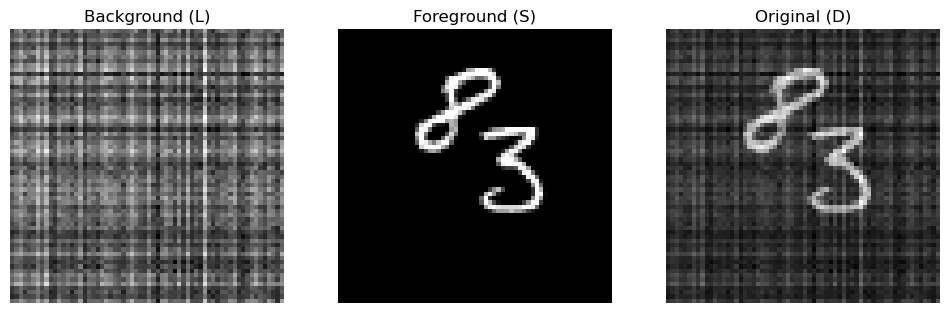

Plot for random predicted frame in 6


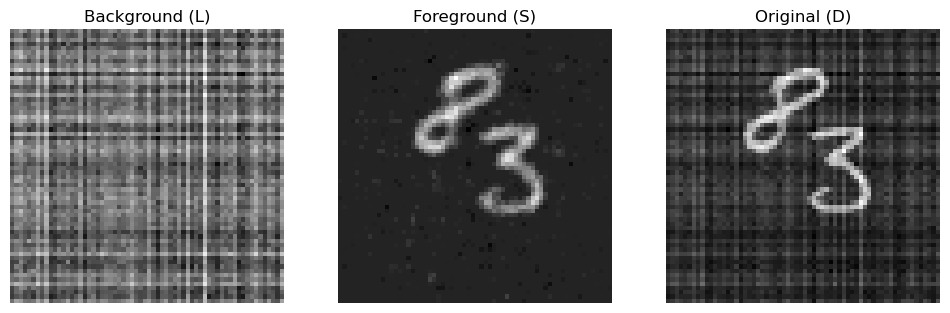

Test Loss: 0.0102
all_singular_values: [[6.2784905, 6.1450853, 7.154135, 8.371637, 27.849697], [6.2223787, 6.118441, 7.113557, 8.33787, 27.493525], [6.240452, 6.115056, 7.113431, 8.31719, 27.629547], [6.270544, 6.1145334, 7.1131353, 8.331274, 27.909128], [6.262962, 6.1246367, 7.12964, 8.333379, 27.763546], [6.2337418, 6.1148667, 7.105136, 8.306285, 27.607166], [6.290059, 6.0797415, 7.0943117, 8.312046, 28.273117]]
all_sparsities [[29898.3125, 31720.46875, 34379.1875, 37583.0, 8718.09375], [29657.46875, 31566.1875, 34321.0625, 37540.03125, 8542.5], [29777.40625, 31621.25, 34365.59375, 37585.96875, 8669.96875], [29997.40625, 31782.46875, 34479.71875, 37606.25, 8697.875], [29859.09375, 31682.0, 34378.84375, 37559.1875, 8637.46875], [29746.25, 31613.59375, 34363.125, 37565.21875, 8629.8125], [30260.75, 31910.375, 34549.625, 37703.625, 8663.5]]
avg_sparsities [29885.24107143 31699.47767857 34405.30803571 37591.89732143
  8651.31696429]


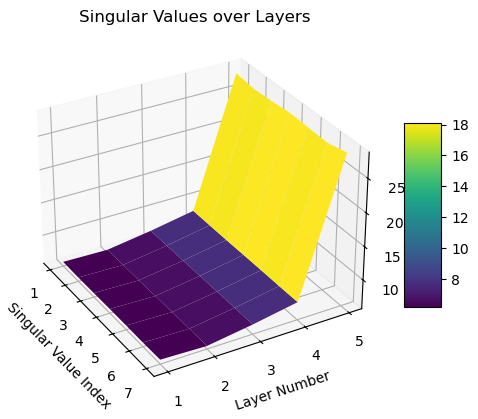

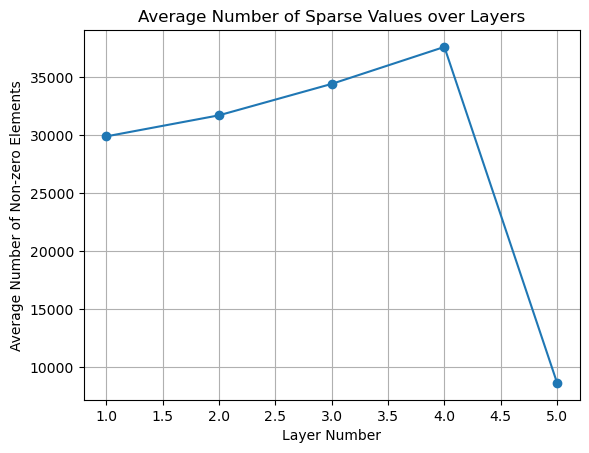

0.010240373685956

In [15]:
# Evaluate the model
evaluate(model, test_loader, loss_fn, configs)